In [11]:
import sqlite3
import pandas as pd
from pandas.plotting import scatter_matrix
try:
    sqlite_connection = sqlite3.connect('data/checking-logs.sqlite.sqlite')
except sqlite3.Error as error:
    print("Ошибка при подключении к sqlite", error)
print('УСПЕШНО')

УСПЕШНО


In [12]:
request = '''
SELECT uid, COUNT(*) AS pageviews
FROM pageviews
WHERE uid LIKE 'user_%'
GROUP BY uid
'''
views = pd.io.sql.read_sql(request, sqlite_connection, parse_dates=['datetime'])
views

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


In [13]:
request = '''
SELECT uid, COUNT(*) AS num_commits
FROM checker
WHERE uid LIKE 'user_%'
AND labname != 'project1'
GROUP BY uid
'''
commits = pd.io.sql.read_sql(request, sqlite_connection, parse_dates=['timestamp'])
commits

,uid,num_commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86
5,user_13,52
6,user_14,61
7,user_15,23
8,user_16,41
9,user_17,51


In [14]:
request = '''
SELECT checker.uid,
       checker.labname, 
       checker.timestamp AS first_commit_ts, 
       pageviews.datetime AS first_view_ts
FROM checker 
LEFT JOIN pageviews ON checker.uid=pageviews.uid
WHERE status='ready'
      AND numTrials=1
      AND labname IN ('laba04', 'laba04s', 'laba05','laba06', 'laba06s', 'project1')
      AND checker.uid LIKE 'user_%'
      AND (pageviews.datetime = (SELECT MIN(pageviews.datetime)
                                 FROM pageviews
                                 WHERE uid=checker.uid
                                 )
                                 OR pageviews.datetime IS NULL
            )
'''
df = pd.io.sql.read_sql(request, sqlite_connection, parse_dates=[
                        'first_commit_ts', 'first_view_ts'])
df = df[df['first_view_ts'].notna()].reset_index(drop=True)
df['avg_diff'] = ((df['first_view_ts'] - df['first_commit_ts']
                   ).dt.total_seconds()).div(3600)
df = df.groupby(['uid']).mean()['avg_diff'].reset_index()
df = df.merge(views, how='inner', on='uid').merge(
    commits, how='inner', on='uid')
df

,uid,avg_diff,pageviews,num_commits
0,user_1,-271.322804,28,62
1,user_10,-456.335203,89,20
2,user_14,-180.824177,143,61
3,user_17,-370.535656,47,51
4,user_18,-124.941028,3,5
5,user_19,-430.049502,16,118
6,user_21,-253.904351,10,65
7,user_25,91.948518,179,79
8,user_28,91.008041,149,60
9,user_3,67.503685,317,18


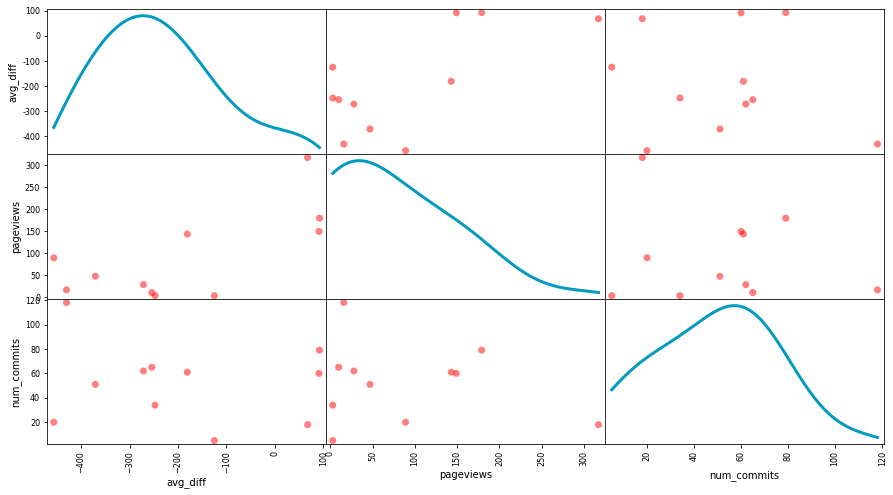

In [15]:
ax = scatter_matrix(df,
                    figsize=(15, 8),
                    diagonal='kde',
                    density_kwds=dict(color='#059ABF', linewidth=3),
                    s=200,
                    color='red')

Can we say that if a user has a low number of pageviews then they likely have a low number of commits?
no

Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?
no

Can we say that there are many users with a low number of commits and a few with a high number of commits?
yes

Can we say that there are many users with a small average difference and a few with a large average difference
no

In [16]:
sqlite_connection.close()